<font size = '5'> <center>**Logistic Regression using Gradient Descent and Maximum Likelihood Estimation**</center> </font>

In this notebook, I have used two different techniques to built a Logistic Regression model from scratch for classification. The first method is by using gradient descent. In this method, the model architecture is very similar to a neural network. The second method used is the maximum likelihood estimation. In this method we will find the best fitting parameters by using a built in optimization function. 

In [7]:
#load the libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
import scipy.optimize as opt
from scipy import stats

The dataset I will be using for this tutorial is a dataset I ran accross while doing the <a href = "http://www.cns.nyu.edu/~eero/math-tools19/"> "Mathematical Tools for Neural and Cognitive Science" </a> course. This is a good introductive course if you want to learning statistical and machine learning techniques.

I will be using the fisher dataset from homework 5. The dataset contains two classes. I will be calling one class the category 1 (represented by 1's) and the other category 2 (represented by 0's). There are 70 samples from each category and each sample has two input variables (represented in x and y axes in Figure 1). 

First let's load the data and organize them.

In [8]:
#import current directory
current_dir = os.getcwd()

#data directory
data_dir = current_dir + '\\data'

#load dataset
data = loadmat(data_dir + '\\fisherdata.mat')

#the two categories of data
cat1 = data['data1']
cat2 = data['data2']

#create the outcome variables for the two categories. cateogiry 1 has an outcome var of 1 and cat 2 has an outcome var of 0
cat1_y = np.ones([len(cat1), 1])
cat2_y = np.zeros([len(cat2), 1])

#combine the two datasets
dataset1 = np.append(cat1, cat1_y, 1)
dataset2 = np.append(cat2, cat2_y, 1)

#make one datasets and shuffle the dataset with a random seed = 1
data = np.vstack([dataset1, dataset2])
np.random.seed(1)
np.random.shuffle(data)

#let's print the data matrix to see what it looks like
print('The data matrix\n')
print(data[:10, :])

#print the number of samples
print('\nThe number of samples is: ', len(data))

The data matrix

[[-0.58225834 -0.33721397  1.        ]
 [ 0.35068347 -0.74906443  1.        ]
 [ 2.3963429   0.09370877  1.        ]
 [ 0.24937456  1.62914414  0.        ]
 [-1.6676351  -0.64697267  1.        ]
 [ 1.04836595  1.37301392  0.        ]
 [ 0.34612302 -0.74578621  1.        ]
 [-1.18120618 -0.62222487  1.        ]
 [ 0.47304268  0.61219905  1.        ]
 [ 2.50027191  0.1570426   0.        ]]

The number of samples is:  140


So the columns of the data matrix represents the input variable 1, input variable 2 and the output category respectively. The rows of the data matrix represent each observation. We cans see there are 140 samples and also the data is mixed.

Below are some utility functions to make predictions and plot data once we finish creating our model.

In [9]:
#function to plot 
def plot_results(w, b, X, Y, Y_pred, title = None, figsize = (10, 7)):
    
    x_vals = np.arange(np.min(X), np.max(X), 0.1)
    y_vals = (- w[0] * x_vals - b)/ w[1]

    plt.figure(figsize = figsize)
    
    for i in range(len(X)):
        
        if (Y_pred[i] == Y[i]) and (Y[i] == 1):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, color = 'r')
            
        if (Y_pred[i] == Y[i]) and (Y[i] == 0):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, color = 'b')
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 1):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, facecolor = 'None', edgecolor = 'r')
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 0):
            
            plt.scatter(X[i, 0], X[i, 1], s = 50, facecolor = 'None', edgecolor = 'b')
    
    if title:
        plt.title(title)
        
    plt.plot(x_vals, y_vals, color = 'k', markersize = '20', linestyle = '--')
    plt.show()    
    

In [10]:
def plot_sigmoid(w, b, X, Y, Y_pred, title = None, figsize = (10, 7)):
           
    #calculate z
    z = X @ w.T + b
    
    #xmin and x max values
    z_min = np.min(z)
    z_max = np.max(z)
    z_vals = np.arange(z_min, z_max, 0.1)
    
    #calcualte sigmoid
    a = sigmoid(z_vals)
    
    #plot sigmoid
    plt.figure(figsize = (figsize))
    plt.plot(z_vals, a, color = 'k', markersize = 10)
    
    for i in range(len(X)):
        
        if (Y_pred[i] == Y[i]) and (Y[i] == 1):
            
            plt.scatter(z[i], Y_pred[i], s = 50, color = 'r', alpha = 0.2)
            
        if (Y_pred[i] == Y[i]) and (Y[i] == 0):
            
            plt.scatter(z[i], Y_pred[i], s = 50, color = 'b', alpha = 0.2)
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 1):
            
            plt.scatter(z[i], Y_pred[i], s = 50, facecolor = 'None', edgecolor = 'r')
            
        if (Y_pred[i] != Y[i]) and (Y[i] == 0):
            
            plt.scatter(z[i], Y_pred[i], s = 50, facecolor = 'None', edgecolor = 'b')
        
    if title:
        plt.title(title)
    
    plt.show()

In [11]:
#funciton to make predictions
def predict(w, b, X, Y):
    
    #calculate the y predictions
    y_hat,_ = forward_propagation(w, b, X, Y)
    
    #append the values
    y_pred = []
    
    #count correct 
    count = 0
    
    for y in range(len(y_hat)):
        
        #make prediction
        prediction = 1.0 if y_hat[y] > 0.5 else 0.0
        y_pred.append(prediction)
        
        if prediction == int(Y[y]):
            count += 1
            
        
    #print prediction accuracy
    print('Prediction accuracy is {} '.format(np.round(count/len(Y)*100), 5), '%')    
    
    return y_pred

Now let's visualize the dataset

- The category 1 (represented by 1's) is in red
- The category 2 (represented by 0's) is in blue
- The x axis represents the input variable 1
- The y axis represents the input variable 2

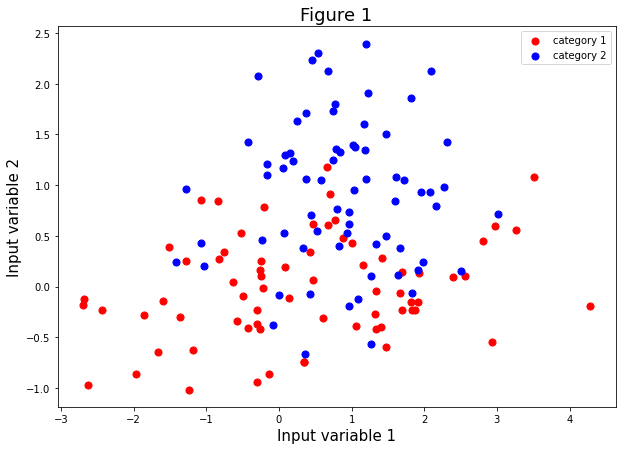

In [12]:
#plot the data
plt.figure(figsize = (10, 7))
plt.scatter(data[data[:, 2] == 1][:, 0], data[data[:, 2] == 1][:, 1], s = 50, color = 'r', label = 'category 1')
plt.scatter(data[data[:, 2] == 0][:, 0], data[data[:, 2] == 0][:, 1], s = 50, color = 'b', label = 'category 2')
plt.title('Figure 1', fontsize = 18)
plt.xlabel('Input variable 1', fontsize = 15)
plt.ylabel('Input variable 2', fontsize = 15)
plt.legend()
plt.show()

So the goal in this tutorial is to use an algorithm (Logistic Regression) to find patterns in this dataset and classify the data to either red or blue categories. Since we already know these categories we can judge how good our model is by evaluating the number of correctly classified data points.

<u>**Logistic Regression using gradient descent**</u>

Logistic Regression (LR) is a very basic but powerful supervised machine learning algorithm used for classification. Here we are implementing LR using numpy. The architecture we are using to build the LR model in this section is very similar to a neural network. If you not familar with neural networks you can also check this <a href = "https://github.com/kaneelgit/ML-DL-Algorithms/blob/main/Hello%20World%20of%20Deep%20Learning.ipynb"> notebook </a> for more information.

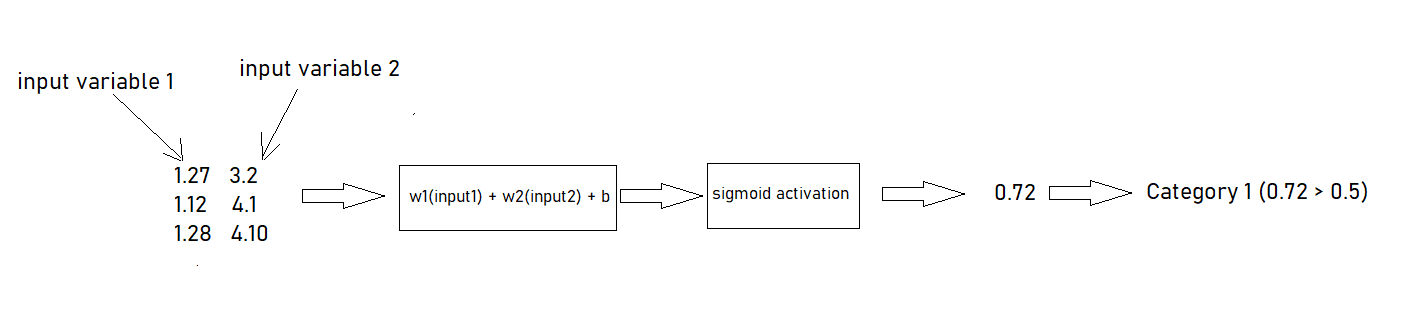

Above is an image that represents how our model make predictions. First we input our data (input variable 1 and input variable 2) to our model. Here we use three parameters (W1, W2 and b) to get a weighted sum for our input data. (Note that the number of parameters depend on the size of the input variables. Since we have two inputs we have one weight for each input and a constant making it a total of three variables) The parameters W1 and W2 represents their influence on our final outcome variable. For example if the input variable 1 is not relavent to our final outcome, then the weight of the input variable 1 (W1 in this case) will be close to zero. In other words, input variable 2 will have more influence towards our final prediction. 

Once we have a weighted sum, we need to find the category for each weighted sum. Here we have two categories, where category 1 is represented by 1's and category 2 is represented by 0's. So next we need to map our weighted sum to either 1 or 0. In order to do this we need to find a function that maps input values to 0 or 1. We can achieve this by the sigmoid activation function (equation 1). (Note that there are other functions such as tanh, relu, leaky relu used in other deep learning techniques, but in logistic regression, it is commonplace to use the sigmoid activation function). 

$$ f(z) = \frac{1}{1 + e^{-z}}\;\;\;->\;equation\;1 $$

$$ where\;in\;our\;example,\;z=w_1.input_1+w_2.input_2+b  $$

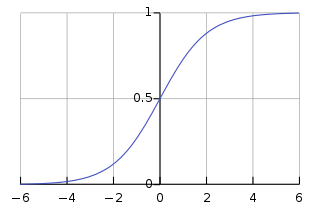

The image above is the output of a sigmoid function. In the x axis we have the input (z) to the sigmoid activation function. The output is a value between 0 and 1. So we can categorize our data by assigning them to their categories based on the value. For example, if we get a 0.56 since the value is greater than 0.5 we assign that sample to the cateogory 1. (similarly we assign all inputs that outputs values less than 0.5 to 0). 

Now let's create a function to define the sigmoid activation.

In [13]:
#sigmoid function
def sigmoid(z):
    """"
    this function takes in the z value and returns it's activation value (between 0 and 1). This also works similarly
    for an input array.
    """
    return 1/(1 + np.exp(-z))

Now let's create a function that generates the forward propagation. 

This function takes the parameter values (w1, w2 and b), the inputs (inp variable 1 and inp variable 2) and the output categories of each input variable. Then it weights the input variables based on the parameters and use the sigmoid activation function to generate a value between 0 and 1.

We will also create a function that initialize our parameter values. We will initialize our w1 and w2 parameters as a random value and the b parameter as zero.

In [22]:
def forward_propagation(w, b, X, Y):
    
    #calculate z
    z = X @ w.T + b
    
    #calculate the activation using the sigmoid function
    y_hat = sigmoid(z)
    
    #calculate the cost 
    cost = calculate_cost(Y, y_hat)
    
    return y_hat, cost

#initialize the parameters
def initialize_parameters():
    
    w = np.random.normal([2, 1])
    b = 0
    
    return w, b


Now that we have initialized our parameters and defined our forward propagation, let's check how well our model makes predictions.

In [23]:
#get X and Y data
X = data[:, :2]
Y = data[:, 2]

#first initialize our parameters
w, b = initialize_parameters()

#calculate forward propagation to get predictions
y_pred, _ = forward_propagation(w, b, X, Y)

#lets find our accuracy using the predict utility function we created 
y_preds = predict(w, b, X, Y)

Prediction accuracy is 31.0  %


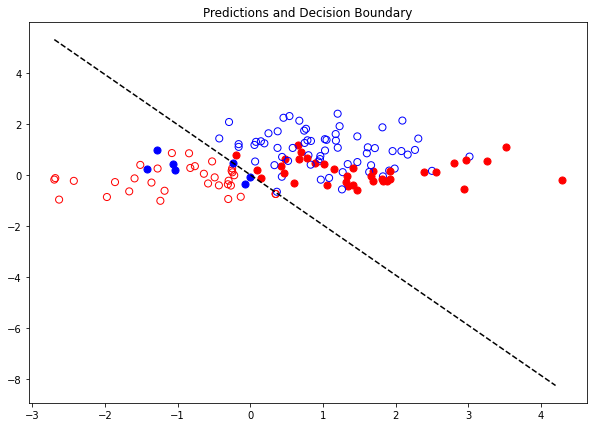

In [24]:
plot_results(w, b, X, Y, y_preds, 'Predictions and Decision Boundary')

In [5]:
def forward_propagation(w, b, X, Y):
    
    #calculate z
    z = X @ w.T + b
    
    #calculate the activation using the sigmoid function
    y_hat = sigmoid(z)
    
    #calculate the cost 
    cost = calculate_cost(Y, y_hat)
    
    return y_hat, cost


#back propagation to find the optimal parameter values   
def backward_propagation(y_pred, Y, X):
    
    #calculate m
    m = len(Y)
    
    #calculate the derivatives
    dw = 1/m * ((y_pred - Y) @ X)
    db = 1/m * np.sum(y_pred - Y)
    
    return dw, db

#cost function
def calculate_cost(y_true, y_pred):
    
    #length of the predictions
    m = len(y_true)
    
    #calculate cost
    cost = np.sum(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
    cost = cost/m
    
    return cost

In [9]:
def optimize_parameters(X, Y, learning_rate = 0.01, num_its = 1000):
    
    #append values
    costs, w1, w2, constant = [], [], [], []
    
    
    #initialize parameters
    w, b = initialize_parameters()
    
    for i in range(num_its):
        
        #propagate forward
        y_hat, cost = forward_propagation(w, b, X, Y)
        
        #propagate backwards
        dw, db = backward_propagation(y_hat, Y, X)
        
        #collect the parameters
        costs.append(cost)
        w1.append(w[0])
        w2.append(w[1])
        constant.append(b)
        
        #update weights
        w = w - learning_rate * dw
        b = b - learning_rate * db
                
        #print cost and prediction accuracy
        if i % 500 == 0:
            
            print('------\n')
            print('After iteration {}'.format(i))
            print('Cost is ', cost)
            #find accuracy and predicted values
            y_preds = predict(w, b, X, Y)
            #plot results
            plot_results(w, b, X, Y, y_preds, 'Predictions and Decision Boundary', (4, 2))
            plot_sigmoid(w, b, X, Y, y_preds, 'Sigmoid function and predictions', (4, 2))
                        
    return w, b, costs, w1, w2, constant

------

After iteration 0
Cost is  1.4745342562859882
Prediction accuracy is 44.0  %


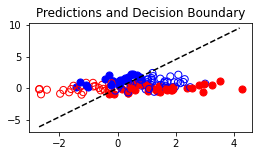

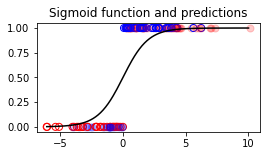

------

After iteration 500
Cost is  0.7525252997796874
Prediction accuracy is 56.0  %


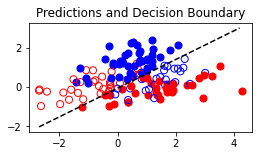

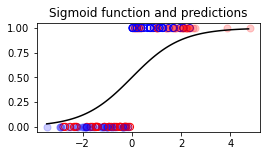

------

After iteration 1000
Cost is  0.5573202449333688
Prediction accuracy is 68.0  %


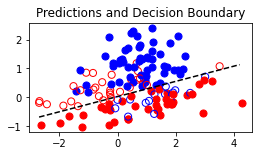

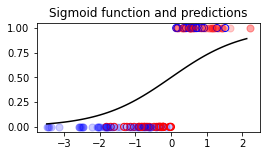

------

After iteration 1500
Cost is  0.5119650442614504
Prediction accuracy is 74.0  %


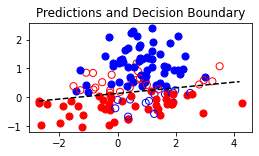

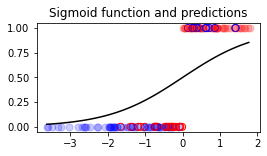

------

After iteration 2000
Cost is  0.4948393611449839
Prediction accuracy is 74.0  %


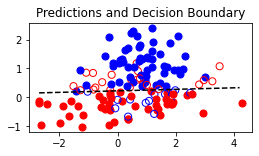

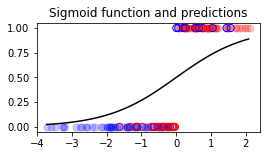

------

After iteration 2500
Cost is  0.48610417586440663
Prediction accuracy is 76.0  %


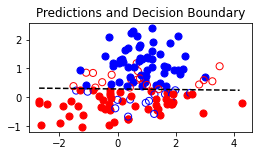

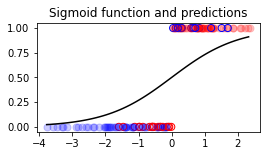

------

After iteration 3000
Cost is  0.4810567954616766
Prediction accuracy is 77.0  %


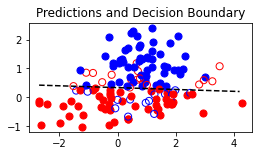

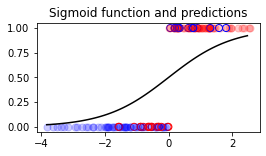

------

After iteration 3500
Cost is  0.4778955257951046
Prediction accuracy is 79.0  %


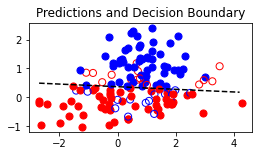

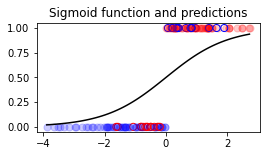

------

After iteration 4000
Cost is  0.4757814234946466
Prediction accuracy is 78.0  %


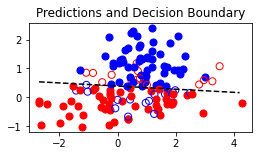

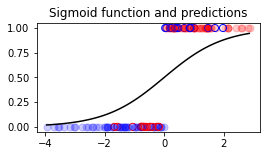

------

After iteration 4500
Cost is  0.4742907684863862
Prediction accuracy is 77.0  %


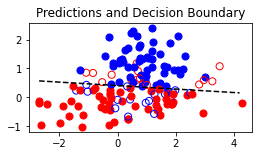

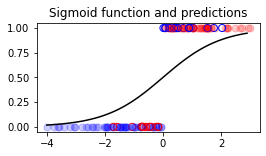

In [10]:
#run the algorith for 5000 iterations

#get X and Y data
X = data[:, :2]
Y = data[:, 2]

w, b, costs, w1, w2, constant = optimize_parameters(X, Y, learning_rate = 0.005, num_its = 5000)

In [11]:
#find accuracy and predicted values
y_preds = predict(w, b, X, Y)

Prediction accuracy is 77.0  %


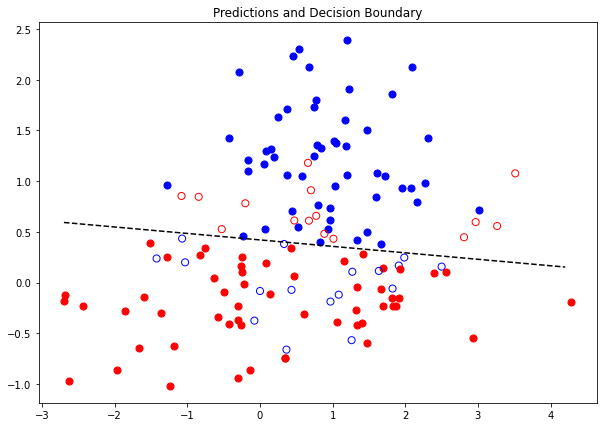

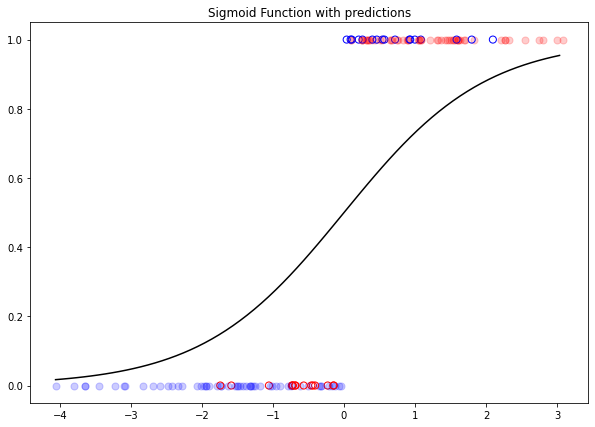

In [12]:
#plot results
plot_results(w, b, X, Y, y_preds, 'Predictions and Decision Boundary')
plot_sigmoid(w, b, X, Y, y_preds, title = 'Sigmoid Function with predictions')

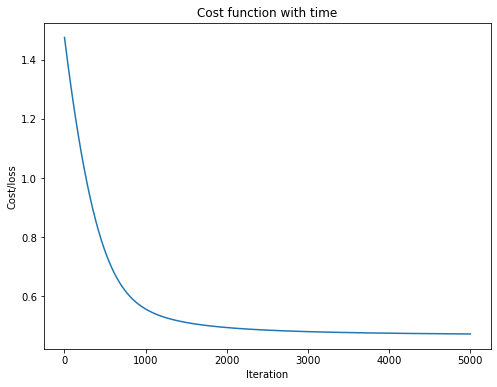

In [13]:
#cost
plt.figure(figsize = (8, 6))
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost/loss')
plt.title('Cost function with time')
plt.show()

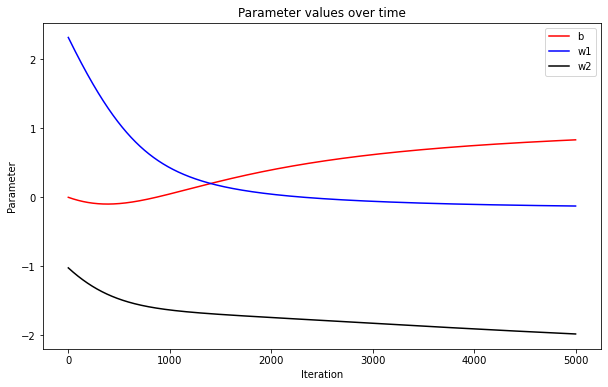

In [18]:
#plot the parameters with loss
plt.figure(figsize = (10, 6))
plt.plot(constant, color = 'r', label = 'b')
plt.plot(w1, color = 'b', label = 'w1')
plt.plot(w2, color = 'k', label = 'w2')
plt.xlabel('Iteration')
plt.ylabel('Parameter')
plt.title('Parameter values over time')
plt.legend()
plt.show()


Logistic regression using maximum likelihood


In [31]:
#create a function to calculate the cost
def negative_log_likelihood(par, X, Y):
    
    #calculate the sigmoid
    Z = X[:, 0] * par[0] + X[:, 1] * par[1] + par[2]
    
    #cumulative probability distribution
    Y_pred = sigmoid(Z)
    
    #negative log likelihood
    nll = np.sum(-Y * np.log(Y_pred) - (1 - Y) * np.log(1 - Y_pred))
    
    return nll

In [47]:
#use fmin to find the optimal values
params = opt.fmin(negative_log_likelihood, x0 = [2, 2, 0], args = (X, Y))
params = np.round(params, 4)

Optimization terminated successfully.
         Current function value: 65.669531
         Iterations: 200
         Function evaluations: 358


In [48]:
#print params
print('Values obtained by maximum likelihood estimation: \n W1: {} \n W2: {} \n b: {}'.format(params[0], params[1], params[2]))

Values obtained by maximum likelihood estimation: 
 W1: -0.1603 
 W2: -2.3603 
 b: 1.0788


In [49]:
#get y predictions
y_preds = predict(params[:2], params[2], X, Y)

Prediction accuracy is 76.0  %


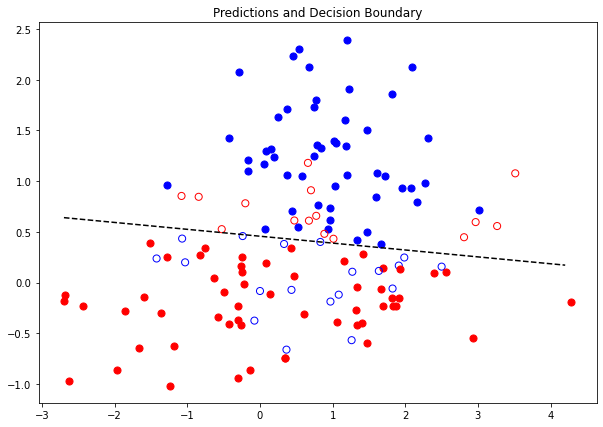

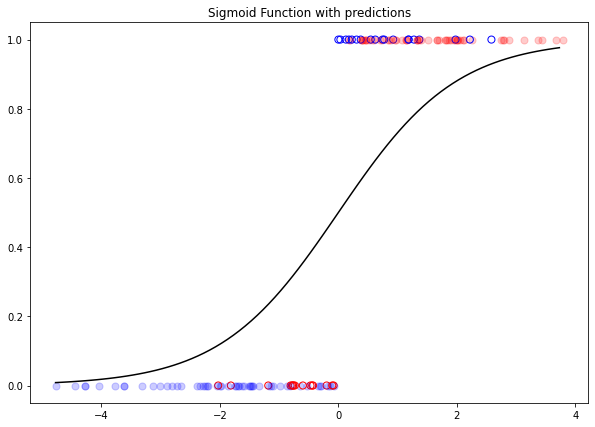

In [50]:
#plot the results
plot_results(params[:2], params[2], X, Y, y_preds, 'Predictions and Decision Boundary')
plot_sigmoid(params[:2], params[2], X, Y, y_preds, title = 'Sigmoid Function with predictions')